In [5]:
# Install necessary dependencies (Google Colab or Local)
!pip install -r ../requirements.txt


In [19]:
import pandas as pd
import plotly.express as px
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
import umap
import hdbscan
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
import nltk



In [7]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/gaia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/gaia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/gaia/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/gaia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/gaia/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
# Set Plotly renderer explicitly to 'notebook'
pio.renderers.default = 'notebook'

In [9]:
# Load cleaned data
data_path = '../dataset/cleaned_events.csv'


In [10]:
# Data Loading and Preparation

def load_and_prepare_data(data_path: str) -> pd.DataFrame:
    """
    Load and filter data based on the top 5 event categories.

    Args:
        data_path (str): Path to the cleaned dataset CSV file.

    Returns:
        pd.DataFrame: Filtered dataframe with the top 5 event categories.
    """
    events_df = pd.read_csv(data_path, encoding='ISO-8859-1', encoding_errors='replace')
    top_categories = events_df['categories'].value_counts().nlargest(5).index
    return events_df[events_df['categories'].isin(top_categories)]

In [11]:
def create_embeddings(df: pd.DataFrame, model_name: str = 'sentence-transformers/all-MiniLM-L6-v2') -> pd.DataFrame:
    """
    Generate sentence embeddings for the combined text data.

    Args:
        df (pd.DataFrame): Dataframe containing event data.
        model_name (str): The name of the pre-trained sentence transformer model.

    Returns:
        pd.DataFrame: Scaled sentence embeddings.
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(df['combined_text'].tolist())
    
    # Standardize the embeddings
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
    return scaled_embeddings


### PCA
##### Principal Component Analysis (PCA):

  - PCA is a technique used to simplify and understand complex datasets.

  - It reduces the dimensionality of data by finding new variables called principal components that capture the most important patterns.

  - PCA focuses on capturing global linear relationships in the data.

  - It helps identify the main sources of variation and allows data visualization in a lower-dimensional space.

  - PCA is useful for tasks like feature selection, data compression, and noise reduction.

In [14]:
# 1. PCA and KMeans Clustering with Plot

def pca_kmeans_clustering(embeddings: pd.DataFrame, df: pd.DataFrame, num_clusters: int = 5) -> pd.DataFrame:
    """
    Apply PCA and KMeans clustering to the embeddings, with visualization.

    Args:
        embeddings (pd.DataFrame): Scaled embeddings.
        df (pd.DataFrame): Original dataframe to add clustering results.
        num_clusters (int): Number of clusters for KMeans.

    Returns:
        pd.DataFrame: Dataframe with PCA components and cluster labels.
    """
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(pca_embeddings)

    # Add the PCA components and cluster labels to the dataframe
    df['PCA1'] = pca_embeddings[:, 0]
    df['PCA2'] = pca_embeddings[:, 1]
    df['Cluster'] = clusters

    # Plot PCA results
    fig = px.scatter(df, x='PCA1', y='PCA2', color='Cluster', hover_data=['clean_title', 'categories'],
                     title='PCA of Event Embeddings with K-means Clustering')
    fig.update_layout(xaxis_title='PCA1', yaxis_title='PCA2', legend_title='Cluster', hovermode='closest')
    fig.show()

    return df

df = load_and_prepare_data(data_path)
embeddings = create_embeddings(df)
pca_kmeans_clustering(embeddings, df, num_clusters=5)
pca_kmeans_clustering(embeddings, df, num_clusters=10)


thread_id  page_id  comment_id    user_id              username  \
0        4895638        0           1  1281314.0            Risty Moon   
1        2679019        0           1    86907.0             needmoney   
2        5252517        0           1  2794182.0           PorExchange   
4        5112064        0           1  2356569.0              BountyZZ   
6        2357581        0           1  1267364.0    etherflyerofficial   
...          ...      ...         ...        ...                   ...   
10106    5285787        0           1  2713348.0  LargoCoin Foundation   
10107    2726458        0           1  1169541.0                 Midex   
10108    5320034        0           1  3166084.0         BitgameGlobal   
10109    5133604        0           1  2068930.0              ruoshui2   
10111    5364153        0           1  3123841.0            Crypo baba   

             post_time   replies    views   active          categories  ...  \
0      14/08/2018 18:21     210.0   4260.0   False              Bounty  ...   
1      02/01/2018 16:08    6144.0  47325.0   False              Bounty  ...   
2      01/06/2020 09:43       1.0     97.0   False               Other  ...   
4      20/02/2019 00:40    7662.0  52271.0   False              Bounty  ...   
6      04/11/2017 15:01     131.0  15612.0   False         Bounty, ICO  ...   
...                 ...       ...      ...     ...                 ...  ...   
10106  31/10/2020 19:37      23.0    805.0   False  Bounty(LowQuality)  ...   
10107  11/01/2018 10:42     363.0  10103.0   False              Bounty  ...   
10108  25/02/2021 10:42       0.0    204.0   False  Bounty(LowQuality)  ...   
10109  19/04/2019 11:25       0.0    193.0   False  Bounty(LowQuality)  ...   
10111  05/10/2021 20:56       0.0    108.0   False             Airdrop  ...   

      author_comment_count                              processed_clean_title  \
0                      1.0                     Angenium Project Bounty Thread   
1                     38.0               YOURBLOCK BOUNTY IS OVER IN TH WEEK    
2                      0.0                          Campaign ProEX Magic Pool   
4                      9.0                  DigitalBits An Economy Reimagined   
6                      3.0          TCASH New Decentralized Exchange Platform   
...                    ...                                                ...   
10106                  0.0                     LARGO COIN looking AMBASSADORS   
10107                 67.0  Midex Financial platform LICENSED exchange str...   
10108                  0.0     Bitgame Youtube Contest Make Review  Win Prize   
10109                  0.0                  Quiz Bounty Getting GXC Right Now   
10111                  0.0   NFT Global The world first NFT Artist Management   

                                      processed_post_tex  \
0         Angenium Bounty Campaign officially ended  ...   
1         HELLO EVERYONE  TEAM HAS DECIDED TO END THE...   
2      ProEXs new campaign ProEX Magic Pool online  J...   
4         This image longer available     Visit tinyp...   
6         NOTE  TCASH Official Main Thread  TCASH Eth...   
...                                                  ...   
10106            Largo Coin       Ambassadors        ...   
10107     Midex Blockchain based Financial platform L...   
10108        BitGame prepared great new contest BitGa...   
10109     Quiz Bounty Getting GXC Right Now      DO Y...   
10111     fr GLOBAL       AIRDROP PROGRAM        USD ...   

                               clean_title_tokens  \
0                           project bounty thread   
1                                  bounty th week   
2                             campaign magic pool   
4                                         economy   
6                           new exchange platform   
...                                           ...   
10106                          largo coin looking   
10107  fi platform licensed exchange strong token  

### t-SNE
##### t-SNE (t-Distributed Stochastic Neighbor Embedding):

  - t-SNE is a visualization technique that helps us understand and explore high-dimensional data.

  - It emphasizes preserving local relationships and clusters within the data.

  - t-SNE constructs a lower-dimensional representation where similar data points are placed closer together.

  - It is particularly useful for visualizing complex datasets and identifying patterns or clusters that may not be apparent in the original high-dimensional space.

  - t-SNE is commonly used for exploratory data analysis, pattern recognition, and clustering tasks.

In [15]:
# 2. t-SNE and KMeans Clustering with Plot

def tsne_kmeans_clustering(embeddings: pd.DataFrame, df: pd.DataFrame, num_clusters: int = 5) -> pd.DataFrame:
    """
    Apply t-SNE and KMeans clustering to the embeddings, with visualization.

    Args:
        embeddings (pd.DataFrame): Scaled embeddings.
        df (pd.DataFrame): Original dataframe to add clustering results.
        num_clusters (int): Number of clusters for KMeans.

    Returns:
        pd.DataFrame: Dataframe with t-SNE components and cluster labels.
    """
    tsne = TSNE(n_components=2, random_state=0)
    tsne_embeddings = tsne.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    clusters = kmeans.fit_predict(tsne_embeddings)

    # Add t-SNE components and cluster labels
    df['TSNE1'] = tsne_embeddings[:, 0]
    df['TSNE2'] = tsne_embeddings[:, 1]
    df['Cluster'] = clusters

    # Plot t-SNE results
    fig_tsne = px.scatter(df, x='TSNE1', y='TSNE2', color='Cluster', hover_data=['clean_title', 'categories'],
                          title='t-SNE of Event Embeddings with K-means Clustering')
    fig_tsne.update_layout(xaxis_title='TSNE1', yaxis_title='TSNE2', legend_title='Cluster', hovermode='closest')
    fig_tsne.show()

    return df

tsne_kmeans_clustering(embeddings, df, num_clusters=5)
tsne_kmeans_clustering(embeddings, df, num_clusters=10)

thread_id  page_id  comment_id    user_id              username  \
0        4895638        0           1  1281314.0            Risty Moon   
1        2679019        0           1    86907.0             needmoney   
2        5252517        0           1  2794182.0           PorExchange   
4        5112064        0           1  2356569.0              BountyZZ   
6        2357581        0           1  1267364.0    etherflyerofficial   
...          ...      ...         ...        ...                   ...   
10106    5285787        0           1  2713348.0  LargoCoin Foundation   
10107    2726458        0           1  1169541.0                 Midex   
10108    5320034        0           1  3166084.0         BitgameGlobal   
10109    5133604        0           1  2068930.0              ruoshui2   
10111    5364153        0           1  3123841.0            Crypo baba   

             post_time   replies    views   active          categories  ...  \
0      14/08/2018 18:21     210.0   4260.0   False              Bounty  ...   
1      02/01/2018 16:08    6144.0  47325.0   False              Bounty  ...   
2      01/06/2020 09:43       1.0     97.0   False               Other  ...   
4      20/02/2019 00:40    7662.0  52271.0   False              Bounty  ...   
6      04/11/2017 15:01     131.0  15612.0   False         Bounty, ICO  ...   
...                 ...       ...      ...     ...                 ...  ...   
10106  31/10/2020 19:37      23.0    805.0   False  Bounty(LowQuality)  ...   
10107  11/01/2018 10:42     363.0  10103.0   False              Bounty  ...   
10108  25/02/2021 10:42       0.0    204.0   False  Bounty(LowQuality)  ...   
10109  19/04/2019 11:25       0.0    193.0   False  Bounty(LowQuality)  ...   
10111  05/10/2021 20:56       0.0    108.0   False             Airdrop  ...   

                                      processed_post_tex  \
0         Angenium Bounty Campaign officially ended  ...   
1         HELLO EVERYONE  TEAM HAS DECIDED TO END THE...   
2      ProEXs new campaign ProEX Magic Pool online  J...   
4         This image longer available     Visit tinyp...   
6         NOTE  TCASH Official Main Thread  TCASH Eth...   
...                                                  ...   
10106            Largo Coin       Ambassadors        ...   
10107     Midex Blockchain based Financial platform L...   
10108        BitGame prepared great new contest BitGa...   
10109     Quiz Bounty Getting GXC Right Now      DO Y...   
10111     fr GLOBAL       AIRDROP PROGRAM        USD ...   

                               clean_title_tokens  \
0                           project bounty thread   
1                                  bounty th week   
2                             campaign magic pool   
4                                         economy   
6                           new exchange platform   
...                                           ...   
10106                          largo coin looking   
10107  fi platform licensed exchange strong token   
10108               contest make review win prize   
10109                   quiz bounty getting right   
10111              global first artist management   

                                         post_tex_tokens  \
0      bounty campaign officially ended please submit...   
1      everyone team decided end bounty count haste l...   
2      new campaign magic join roi information campai...   
4      image longer protocol layer designed help faci...   
6      official main thread truly solid exchange powe...   
...                                                  ...   
10106  largo coin ambassador looking passionate good ...   
10107  based fi platform licensed exchange swiss ann ...   
10108  prepared great new contest simple always absol...   
10109  bounty getting right know u get quiz q trading...   
10111  worth token global disrupter definitely change...   

                                    general_rules_tokens  \
0      week general join bount

### DBSCAN

##### Density-Based Spatial Clustering of Applications with Noise

- DBSCAN views clusters as areas of high density separated by areas of low density.

- Clusters found by DBSCAN can be any shape, unlike k-means which assumes convex-shaped clusters.

- The central component of DBSCAN is core samples, which are in areas of high density.

- A cluster consists of core samples close to each other and non-core samples close to a core sample.

- DBSCAN has two parameters: min_samples and eps, defining density.

- The parameter min_samples affects noise tolerance, while eps must be chosen appropriately for the data set.

- Incorrect eps values can result in either no clusters (too small) or merging of close clusters into one (too large).


In [16]:
# 3. t-SNE and DBSCAN Clustering with Plot

def tsne_dbscan_clustering(embeddings: pd.DataFrame, df: pd.DataFrame, eps: float = 0.9, min_samples: int = 5) -> pd.DataFrame:
    """
    Apply t-SNE and DBSCAN clustering to the embeddings, with visualization.

    Args:
        embeddings (pd.DataFrame): Scaled embeddings.
        df (pd.DataFrame): Original dataframe to add clustering results.
        eps (float): The maximum distance between two samples for them to be considered as in the same neighborhood (DBSCAN parameter).
        min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point (DBSCAN parameter).

    Returns:
        pd.DataFrame: Dataframe with t-SNE components and DBSCAN cluster labels.
    """
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(tsne_embeddings)

    # Add the t-SNE components and cluster labels to the dataframe
    df['TSNE1'] = tsne_embeddings[:, 0]
    df['TSNE2'] = tsne_embeddings[:, 1]
    df['Cluster'] = clusters

    # Plot t-SNE with DBSCAN clusters
    fig_tsne = px.scatter(df, x='TSNE1', y='TSNE2', color='Cluster', hover_data=['clean_title', 'categories'],
                          title='t-SNE of Event Embeddings with DBSCAN Clustering')
    fig_tsne.update_layout(xaxis_title='TSNE Component 1', yaxis_title='TSNE Component 2', legend_title='Cluster', hovermode='closest')
    fig_tsne.show()

    return df

tsne_dbscan_clustering(embeddings, df, eps=0.9, min_samples=5)

thread_id  page_id  comment_id    user_id              username  \
0        4895638        0           1  1281314.0            Risty Moon   
1        2679019        0           1    86907.0             needmoney   
2        5252517        0           1  2794182.0           PorExchange   
4        5112064        0           1  2356569.0              BountyZZ   
6        2357581        0           1  1267364.0    etherflyerofficial   
...          ...      ...         ...        ...                   ...   
10106    5285787        0           1  2713348.0  LargoCoin Foundation   
10107    2726458        0           1  1169541.0                 Midex   
10108    5320034        0           1  3166084.0         BitgameGlobal   
10109    5133604        0           1  2068930.0              ruoshui2   
10111    5364153        0           1  3123841.0            Crypo baba   

             post_time   replies    views   active          categories  ...  \
0      14/08/2018 18:21     210.0   4260.0   False              Bounty  ...   
1      02/01/2018 16:08    6144.0  47325.0   False              Bounty  ...   
2      01/06/2020 09:43       1.0     97.0   False               Other  ...   
4      20/02/2019 00:40    7662.0  52271.0   False              Bounty  ...   
6      04/11/2017 15:01     131.0  15612.0   False         Bounty, ICO  ...   
...                 ...       ...      ...     ...                 ...  ...   
10106  31/10/2020 19:37      23.0    805.0   False  Bounty(LowQuality)  ...   
10107  11/01/2018 10:42     363.0  10103.0   False              Bounty  ...   
10108  25/02/2021 10:42       0.0    204.0   False  Bounty(LowQuality)  ...   
10109  19/04/2019 11:25       0.0    193.0   False  Bounty(LowQuality)  ...   
10111  05/10/2021 20:56       0.0    108.0   False             Airdrop  ...   

                                      processed_post_tex  \
0         Angenium Bounty Campaign officially ended  ...   
1         HELLO EVERYONE  TEAM HAS DECIDED TO END THE...   
2      ProEXs new campaign ProEX Magic Pool online  J...   
4         This image longer available     Visit tinyp...   
6         NOTE  TCASH Official Main Thread  TCASH Eth...   
...                                                  ...   
10106            Largo Coin       Ambassadors        ...   
10107     Midex Blockchain based Financial platform L...   
10108        BitGame prepared great new contest BitGa...   
10109     Quiz Bounty Getting GXC Right Now      DO Y...   
10111     fr GLOBAL       AIRDROP PROGRAM        USD ...   

                               clean_title_tokens  \
0                           project bounty thread   
1                                  bounty th week   
2                             campaign magic pool   
4                                         economy   
6                           new exchange platform   
...                                           ...   
10106                          largo coin looking   
10107  fi platform licensed exchange strong token   
10108               contest make review win prize   
10109                   quiz bounty getting right   
10111              global first artist management   

                                         post_tex_tokens  \
0      bounty campaign officially ended please submit...   
1      everyone team decided end bounty count haste l...   
2      new campaign magic join roi information campai...   
4      image longer protocol layer designed help faci...   
6      official main thread truly solid exchange powe...   
...                                                  ...   
10106  largo coin ambassador looking passionate good ...   
10107  based fi platform licensed exchange swiss ann ...   
10108  prepared great new contest simple always absol...   
10109  bounty getting right know u get quiz q trading...   
10111  worth token global disrupter definitely change...   

                                    general_rules_tokens  \
0      week general join bount

### HDBSCAN

##### Hierarchical Density-Based Spatial Clustering of Applications with Noise

- Performs DBSCAN over varying epsilon values and integrates the results. This integration finds a clustering that provides the best stability over epsilon.

- HDBSCAN can find clusters of varying densities, unlike DBSCAN.

- HDBSCAN is more robust to parameter selection compared to DBSCAN.

- HDBSCAN explores all possible density scales, providing a flexible clustering solution.

In [17]:
# 4. UMAP and HDBSCAN Clustering with Plot

def tsne_hdbscan_clustering(embeddings: pd.DataFrame, df: pd.DataFrame, min_cluster_size: int = 15, min_samples: int = 7) -> None:
    """
    Apply t-SNE and HDBSCAN clustering to the embeddings, with visualization.

    Args:
        embeddings (pd.DataFrame): Scaled embeddings.
        df (pd.DataFrame): Original dataframe to add clustering results.
        min_cluster_size (int): The minimum size of clusters for HDBSCAN.
        min_samples (int): The number of samples in a neighborhood for a point to be considered a core point (HDBSCAN parameter).
    """
    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=0)
    tsne_embeddings = tsne.fit_transform(embeddings)

    # Apply HDBSCAN clustering
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusters = hdbscan_clusterer.fit_predict(tsne_embeddings)

    # Add the t-SNE components and cluster labels to the dataframe
    df['TSNE1'] = tsne_embeddings[:, 0]
    df['TSNE2'] = tsne_embeddings[:, 1]
    df['Cluster'] = clusters

    # Plot t-SNE with HDBSCAN clusters
    fig_tsne = px.scatter(df, x='TSNE1', y='TSNE2', color='Cluster', hover_data=['clean_title', 'categories'],
                          title=f't-SNE of Event Embeddings with HDBSCAN Clustering (min_cluster_size={min_cluster_size}, min_samples={min_samples})')
    fig_tsne.update_layout(xaxis_title='t-SNE Component 1', yaxis_title='t-SNE Component 2', legend_title='Cluster', hovermode='closest')
    fig_tsne.show()

tsne_hdbscan_clustering(embeddings, df, min_cluster_size=15, min_samples=7)

### UMAP and HDBSAN

##### Uniform Manifold Approximation and Projection 

- UMAP is a dimensionality reduction and manifold learning technique.

- t-SNE is also a commonly used technique for cluster visualization but has drawbacks for density-based clustering. t-SNE preserves local structure but often fails to preserve global structure and density.

- HDBSCAN works well with UMAP, despite UMAP’s uniform density assumption, which does not preserve density well.


In [18]:
# 5. BERTopic Clustering with Plot

def umap_hdbscan_clustering(embeddings: pd.DataFrame, df: pd.DataFrame) -> None:
    """
    Apply UMAP and HDBSCAN clustering to the embeddings, with visualization.

    Args:
        embeddings (pd.DataFrame): Scaled embeddings.
        df (pd.DataFrame): Original dataframe to add clustering results.
    """
    # Apply UMAP for dimensionality reduction
    umap_model = umap.UMAP(n_components=2, n_neighbors=10, min_dist=0.15, random_state=0)
    umap_embeddings = umap_model.fit_transform(embeddings)

    # Apply HDBSCAN clustering
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=7)
    clusters = hdbscan_clusterer.fit_predict(umap_embeddings)

    # Add the UMAP components and cluster labels to the dataframe
    df['UMAP1'] = umap_embeddings[:, 0]
    df['UMAP2'] = umap_embeddings[:, 1]
    df['Cluster'] = clusters

    # Plot UMAP with HDBSCAN clusters
    fig_umap = px.scatter(df, x='UMAP1', y='UMAP2', color='Cluster', hover_data=['clean_title', 'categories'],
                          title='UMAP of Event Embeddings with HDBSCAN Clustering')
    fig_umap.update_layout(xaxis_title='UMAP Component 1', yaxis_title='UMAP Component 2', legend_title='Cluster', hovermode='closest')
    fig_umap.show()

umap_hdbscan_clustering(embeddings, df)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### BERTopic

##### Main Features of BERTopic:
- Minimal Preprocessing: Typically no need for extensive preprocessing due to the use of document transformer-based embeddings.
- Versatile Embedding Models: Supports various embedding models including SentenceTransformer, Gensim, Flair, and Spacy.
- Document Embedding: Uses sentence-transformers for creating document embeddings.
- Dimensionality Reduction: Applies UMAP to reduce dimensionality while preserving local and global structures.
- Density-Based Clustering: Uses HDBSCAN to create topic clusters and identify outliers.
- Topic Representation: Employs c-TF-IDF for creating coherent and interpretable topic descriptions.
- Visualization Tools: Provides robust tools for visualizing topic hierarchies and distributions.


##### Advantages of BERTopic:
- Ease of Use: High-level interface enables quick model building with minimal effort.
- Flexibility: Highly customizable settings to tailor the model to specific use cases.
- Advanced Analysis: Captures semantic similarities and dynamic changes in topics over time.
- Robust Clustering: Handles varying densities and identifies outliers effectively.
- Comprehensive Visualization: Enhances understanding of the semantic structure and topic distributions.
- Efficient Topic Representation: Generates clear and interpretable topic labels.
- Adaptability: Suitable for evolving datasets and dynamic topic analysis.





##### 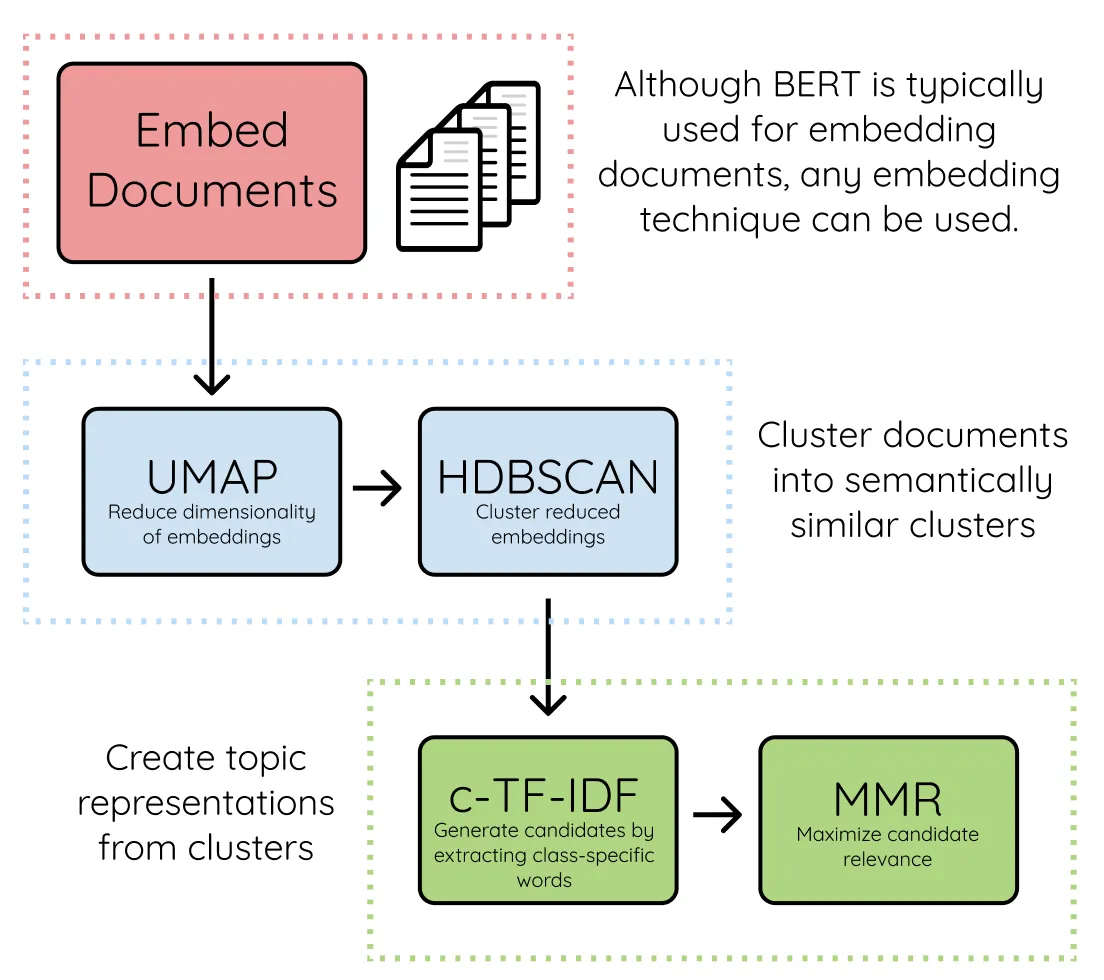

In [21]:
# 6. BERTopic Clustering with Plot

def bertopic_analysis(filtered_events_df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply BERTopic, UMAP, and HDBSCAN clustering to the dataset, with visualizations.

    Args:
        filtered_events_df (pd.DataFrame): Dataframe containing event data with 'combined_text' column.

    Returns:
        pd.DataFrame: Dataframe with topic and cluster information.
    """
    # Step 1 - Extract embeddings using SentenceTransformer
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = embedding_model.encode(filtered_events_df['combined_text'].tolist())
    
    # Step 2 - Reduce dimensionality with UMAP
    umap_model = umap.UMAP(n_neighbors=10, n_components=2, min_dist=0.15, metric='cosine')
    umap_embeddings = umap_model.fit_transform(embeddings)

    # Step 3 - Apply HDBSCAN clustering
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    clusters = hdbscan_model.fit_predict(umap_embeddings)

    # Add UMAP components and clusters to the dataframe
    filtered_events_df['UMAP1'] = umap_embeddings[:, 0]
    filtered_events_df['UMAP2'] = umap_embeddings[:, 1]
    filtered_events_df['Cluster'] = clusters

    # Step 4 - Tokenize topics with CountVectorizer
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation using ClassTfidfTransformer
    ctfidf_model = ClassTfidfTransformer()

    # Step 6 - Fine-tune topic representations with KeyBERTInspired (optional)
    representation_model = KeyBERTInspired()

    # Initialize BERTopic with custom models
    topic_model = BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        representation_model=representation_model  # Optional fine-tuning
    )

    # Fit the BERTopic model
    topics, probabilities = topic_model.fit_transform(filtered_events_df['combined_text'].tolist())

    # Add topic information to the dataframe
    filtered_events_df['Topic'] = topics

    # Visualize the topics
    fig_topics = topic_model.visualize_topics()
    fig_topics.show()

    # Check if probabilities are available and visualize distribution
    if probabilities is not None and len(probabilities) > 0:
        try:
            fig_distribution = topic_model.visualize_distribution(probabilities)
            fig_distribution.show()
        except ValueError as e:
            print(f"Skipping visualize_distribution due to error: {e}")

    # Visualize individual topics with a bar chart
    fig_barchart = topic_model.visualize_barchart()
    fig_barchart.show()

    # UMAP embedding scatter plot with HDBSCAN clusters
    fig_umap_hdbscan = px.scatter(
        filtered_events_df,
        x='UMAP1',
        y='UMAP2',
        color='Cluster',
        hover_data=['clean_title', 'categories', 'Topic'],
        title='UMAP of Event Embeddings with HDBSCAN Clustering for Top 5 Categories'
    )

    fig_umap_hdbscan.update_layout(
        xaxis_title='UMAP Component 1',
        yaxis_title='UMAP Component 2',
        legend_title='Cluster',
        hovermode='closest'
    )

    fig_umap_hdbscan.show()

    # Print clustering and topic information
    print(f"Clustering completed. Number of clusters found: {len(filtered_events_df['Cluster'].unique())}")
    print(f"Number of topics identified: {len(filtered_events_df['Topic'].unique())}")

    return filtered_events_df

bertopic_analysis(df)



Clustering completed. Number of clusters found: 22
Number of topics identified: 19


thread_id  page_id  comment_id    user_id              username  \
0        4895638        0           1  1281314.0            Risty Moon   
1        2679019        0           1    86907.0             needmoney   
2        5252517        0           1  2794182.0           PorExchange   
4        5112064        0           1  2356569.0              BountyZZ   
6        2357581        0           1  1267364.0    etherflyerofficial   
...          ...      ...         ...        ...                   ...   
10106    5285787        0           1  2713348.0  LargoCoin Foundation   
10107    2726458        0           1  1169541.0                 Midex   
10108    5320034        0           1  3166084.0         BitgameGlobal   
10109    5133604        0           1  2068930.0              ruoshui2   
10111    5364153        0           1  3123841.0            Crypo baba   

             post_time   replies    views   active          categories  ...  \
0      14/08/2018 18:21     210.0   4260.0   False              Bounty  ...   
1      02/01/2018 16:08    6144.0  47325.0   False              Bounty  ...   
2      01/06/2020 09:43       1.0     97.0   False               Other  ...   
4      20/02/2019 00:40    7662.0  52271.0   False              Bounty  ...   
6      04/11/2017 15:01     131.0  15612.0   False         Bounty, ICO  ...   
...                 ...       ...      ...     ...                 ...  ...   
10106  31/10/2020 19:37      23.0    805.0   False  Bounty(LowQuality)  ...   
10107  11/01/2018 10:42     363.0  10103.0   False              Bounty  ...   
10108  25/02/2021 10:42       0.0    204.0   False  Bounty(LowQuality)  ...   
10109  19/04/2019 11:25       0.0    193.0   False  Bounty(LowQuality)  ...   
10111  05/10/2021 20:56       0.0    108.0   False             Airdrop  ...   

                                    general_rules_tokens  \
0      week general join bounty first register via ca...   
1      first week bounty campaign start signature dis...   
2                                                    NaN   
4      necessary join telegram main chat bounty chat ...   
6                                                    NaN   
...                                                  ...   
10106                                                NaN   
10107                                                NaN   
10108                                                NaN   
10109                                                NaN   
10111                                                NaN   

                                           combined_text       PCA1      PCA2  \
0      project bounty thread bounty campaign official... -10.741896  2.180896   
1      bounty th week everyone team decided end bount... -10.634466  0.349681   
2      campaign magic pool new campaign magic join ro...   1.120080 -3.293613   
4      economy image longer protocol layer designed h...  -7.371666 -3.680275   
6      new exchange platform official main thread tru...  -6.006495 -3.013229   
...                                                  ...        ...       ...   
10106  largo coin looking largo coin ambassador looki...   5.026998  1.167100   
10107  fi platform licensed exchange strong token bas...  -7.751030 -3.360097   
10108  contest make review win prize prepared great n...   5.347916 -1.457170   
10109  quiz bounty getting right bounty getting right...  -0.412586  3.844560   
10111  global first artist management worth token glo...  10.231457 -1.577975   

      Cluster      TSNE1      TSNE2      UMAP1     UMAP2 Topic  
0          20 -45.058979   8.124508   4.422783 -7.887127     1  
1          20 -47.726070 -19.875803   5.179561 -5.964354     1  
2          17  -5.642391 -46.747295   7.351285 -4.372527     0  
4          20 -25.480196   9.324718   6.148035 -6.777352     1  
6          20 -20.849463 -25.531282   6.506096 -5.639350     1  
...       ...        ...        ...        ...       ...   ...  
10106      17   1.56